# Fetch and export SNOTEL sites and daily time series data

In [1]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import ulmo
import json
import requests
import rioxarray as rxr

In [2]:
#########################################################################
############################ USER INPUTS ################################
#########################################################################

# DOMAIN
# choose the modeling domain
domain = 'BRIS'

# PATHS
dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'

# DATES
#start calibration date    
st_dt = '2011-10-01'
#end calibration date
ed_dt = '2018-09-30'

#########################################################################

In [3]:
# functions to get stations as geodataframe
def sites_asgdf(ulmo_getsites, stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=stn_proj
    )
    return sites_gdf

def get_stns(domain):
    
    #path to domains
    domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
    domains = domains_resp.json()

    #Snotel bounding box
    Bbox = domains[domain]['Bbox']

    # Snotel projection
    stn_proj = domains[domain]['stn_proj']
    # model projection
    mod_proj = domains[domain]['mod_proj']

    # Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
    box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
    box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)
    
    # WaterML/WOF WSDL endpoint url 
    #snotel 
    wsdlurl = "https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

    # get dictionary of snotel sites 
    sites = ulmo.cuahsi.wof.get_sites(wsdlurl,user_cache=True)

    #turn sites to geodataframe 
    snotel_gdf = sites_asgdf(sites,stn_proj)
    
    #clip snotel sites to domain bounding box
    gdf1 = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
    gdf1.drop(columns='index_right', inplace=True)
    gdf1.reset_index(drop=True, inplace=True)
    
    #scan (east coast & AK)
    wsdlurl_scan = "https://hydroportal.cuahsi.org/Scan/cuahsi_1_1.asmx?WSDL"
    
    # get dictionary of scan sites 
    scan_sites = ulmo.cuahsi.wof.get_sites(wsdlurl_scan,user_cache=True)
    
    #turn sites to geodataframe 
    scan_gdf = sites_asgdf(scan_sites,stn_proj)
    
    #clip scan sites to domain bounding box
    gdf2 = gpd.sjoin(scan_gdf, box_gdf, how="inner")
    gdf2.drop(columns='index_right', inplace=True)
    gdf2.reset_index(drop=True, inplace=True)
    
    # concatenate snotel and scan
    frames = [gdf1, gdf2]
    gdfs = pd.concat(frames)

    #add columns with projected coordinates 
    CSO_proj = gdfs.to_crs(mod_proj)
    gdfs['easting'] = CSO_proj.geometry.x
    gdfs['northing'] = CSO_proj.geometry.y
    gdfs.reset_index(drop=True, inplace=True)
    
    return gdfs

In [4]:
def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    #snotel 
    wsdlurl = "https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [5]:
def fetch_scan(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    #scan
    wsdlurl = "https://hydroportal.cuahsi.org/Scan/cuahsi_1_1.asmx?WSDL"
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SCAN:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [6]:
# returns daily timeseries
# https://www.wcc.nrcs.usda.gov/web_service/AWDB_Web_Service_Reference.htm#commonlyUsedElementCodes
# 'WTEQ': swe [in]
# 'SNWD': snow depth [in]
# 'PRCP': precipitation increment [in]
# 'PREC': precipitation accumulation [in]
# 'TAVG': average air temp [F]
# 'TMIN': minimum air temp [F]
# 'TMAX': maximum air temp [F]
# 'TOBS': observered air temp [F]
def get_stn_data(gdf,sd_dt, ed_dt,var,units='metric'):
    '''
    gdf - pandas geodataframe of SNOTEL sites
    st_dt - start date string 'yyyy-mm-dd'
    ed_dt - end date string 'yyyy-mm-dd'
    var - snotel variable of interest 
    units - 'metric' (default) or 'imperial'
    '''
    #empty dataframe for station data
    stn_data = pd.DataFrame(index=pd.date_range(start=st_dt, end=ed_dt))

    for sitecode in gdf.code:
        # get snotel daily data
        if sitecode[-4:] == 'SNTL':
            try:
                data = fetch(sitecode,'SNOTEL:'+var+'_D', start_date=st_dt, end_date=ed_dt)
                stn_data[sitecode] = data.value
            except:
                print('droping '+sitecode)
        # get scan daily data
        if sitecode[-4:] == 'SCAN':
            try:
                data = fetch_scan(sitecode,'SCAN:'+var+'_D', start_date=st_dt, end_date=ed_dt)
                stn_data[sitecode] = data.value
            except:
                print('dropping '+sitecode)
    # grop stations with no data from gdf
    gdffinal = gdf[gdf.code.isin(stn_data.columns)]
    gdffinal.reset_index(drop=True, inplace=True)
    # convert units
    if units == 'metric':
        if (var == 'WTEQ') |(var == 'SNWD') |(var == 'PRCP') |(var == 'PREC'):
            #convert depth units [in] to [m]
            for sitecode in gdffinal.code:
                stn_data[sitecode] = 0.0254 * stn_data[sitecode]
        elif (var == 'TAVG') |(var == 'TMIN') |(var == 'TMAX') |(var == 'TOBS'):
            #convert temp units [F] to [C]
            for sitecode in gdffinal.code:
                stn_data[sitecode] = (stn_data[sitecode] - 32) * 5/9
            # remove missing data
            stn_data[stn_data<-99]=np.nan
    elif units == 'imperial':
        stn_data = stn_data
    return gdffinal, stn_data

In [7]:
def check_stn_bounds(domain,instnGDF):
    #open .tif
    DA = rxr.open_rasterio('/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'+domain+'_dem.tif')
    #get bounds
    bnds = DA.rio.bounds()
    #build bounding box
    box_sgeom = sgeom.box(bnds[0], bnds[1], bnds[2], bnds[3])
    #path to domains
    domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
    domains = domains_resp.json()
    # domain projection
    mod_proj = domains[domain]['mod_proj']
    box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=mod_proj)
    #get geodataframe of all SNOTEL sites in the domain
    stnGDFproj = instnGDF.to_crs(mod_proj)
    #clip snotel sites to domain bounding box
    gdf1 = gpd.sjoin(stnGDFproj, box_gdf, how="inner")
    gdf1.drop(columns='index_right', inplace=True)
    gdf1.reset_index(drop=True, inplace=True)
    return gdf1

BRIS
14
0     1062_AK_SNTL
1      201_AK_SNTL
2     1191_AK_SNTL
3      987_AK_SNTL
4     1266_AK_SNTL
5     1232_AK_SCAN
6     2211_AK_SCAN
7     2208_AK_SCAN
8     1233_AK_SCAN
9     2062_AK_SCAN
10    2209_AK_SCAN
11    2063_AK_SCAN
12    2221_AK_SCAN
13    1234_AK_SCAN
Name: code, dtype: object


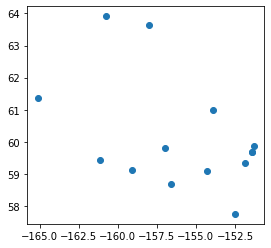

In [8]:
import matplotlib.pyplot as plt
# run all AK domains
domain_list = [domain]

for domain in domain_list:
    print(domain)
    #get geodataframe of all SNOTEL and SCAN sites in the domain
    snotel_gdf = get_stns(domain)
    print(len(snotel_gdf))
    print(snotel_gdf.code)
    if len(snotel_gdf)>0:
        fig, ax = plt.subplots()
        snotel_gdf.plot(ax=ax)

# Execute Functions

In [9]:
#get geodataframe of all SNOTEL and SCAN sites in the domain
stnGDF = get_stns(domain)
#ensure all sites are within domain bounds
stnGDF = check_stn_bounds(domain,stnGDF)

#get observed temp timeseries 
domain_gdfT, tob = get_stn_data(stnGDF,st_dt, ed_dt,'TOBS')

# save geojson
out = dataPath + 'Station_sites_TOBScelcius_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson'
domain_gdfT.to_file(out, driver='GeoJSON')

#save tobs
out = dataPath + 'Station_data_TOBScelsius_'+st_dt+'_'+ed_dt+'.csv'
tob.to_csv(out)

#get precipitation timeseries 
domain_gdfP, pr = get_stn_data(stnGDF,st_dt,ed_dt,'PRCP')

# save geojson
out = dataPath + 'Station_sites_PRmeters_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson'
domain_gdfP.to_file(out, driver='GeoJSON')

#save pr
out = dataPath + 'Station_data_PRmeters_'+st_dt+'_'+ed_dt+'.csv'
pr.to_csv(out)

#get swe timeseries 
domain_gdfSWE, swe = get_stn_data(stnGDF,st_dt,ed_dt,'WTEQ')

# save geojson
out = dataPath + 'Station_sites_SWEDmeters_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson'
domain_gdfSWE.to_file(out, driver='GeoJSON')

#save swe
out = dataPath + 'Station_data_SWEDmeters_'+st_dt+'_'+ed_dt+'.csv'
swe.to_csv(out)

1062_AK_SNTL SNOTEL:TOBS_D 2011-10-01 2018-09-30
201_AK_SNTL SNOTEL:TOBS_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:TOBS_D
droping 201_AK_SNTL
1191_AK_SNTL SNOTEL:TOBS_D 2011-10-01 2018-09-30
987_AK_SNTL SNOTEL:TOBS_D 2011-10-01 2018-09-30
1266_AK_SNTL SNOTEL:TOBS_D 2011-10-01 2018-09-30
1232_AK_SCAN SCAN:TOBS_D 2011-10-01 2018-09-30
2211_AK_SCAN SCAN:TOBS_D 2011-10-01 2018-09-30
2208_AK_SCAN SCAN:TOBS_D 2011-10-01 2018-09-30
1233_AK_SCAN SCAN:TOBS_D 2011-10-01 2018-09-30
2062_AK_SCAN SCAN:TOBS_D 2011-10-01 2018-09-30


Unable to fetch SCAN:TOBS_D
dropping 2062_AK_SCAN
2209_AK_SCAN SCAN:TOBS_D 2011-10-01 2018-09-30
2063_AK_SCAN SCAN:TOBS_D 2011-10-01 2018-09-30


Unable to fetch SCAN:TOBS_D
dropping 2063_AK_SCAN
2221_AK_SCAN SCAN:TOBS_D 2011-10-01 2018-09-30
1234_AK_SCAN SCAN:TOBS_D 2011-10-01 2018-09-30
1062_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
201_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:PRCP_D
droping 201_AK_SNTL
1191_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
987_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1266_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1232_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2211_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2208_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
1233_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2062_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2209_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2063_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2221_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
1234_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
1062_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
201_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 201_AK_SNTL
1191_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1191_AK_SNTL
987_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1266_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1232_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 1232_AK_SCAN
2211_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2211_AK_SCAN
2208_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2208_AK_SCAN
1233_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 1233_AK_SCAN
2062_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2062_AK_SCAN
2209_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2209_AK_SCAN
2063_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2063_AK_SCAN
2221_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2221_AK_SCAN
1234_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 1234_AK_SCAN


# clean data

Each station should be checked to remove bad data.

## BRIS


In [10]:
######## TEMP ########
# PATHS
dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'
t = pd.read_csv(dataPath+'Station_data_TOBScelsius_'+st_dt+'_'+ed_dt+'.csv',index_col=0)
t

,1062_AK_SNTL,1191_AK_SNTL,987_AK_SNTL,1266_AK_SNTL,1232_AK_SCAN,2211_AK_SCAN,2208_AK_SCAN,1233_AK_SCAN,2209_AK_SCAN,2221_AK_SCAN,1234_AK_SCAN
2011-10-01,2.1,NaN,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-02,2.5,NaN,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-03,2.1,NaN,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-04,0.9,NaN,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-05,0.3,NaN,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,NaN,4.4,4.8,5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-27,NaN,9.3,7.4,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-28,NaN,9.2,8.8,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-29,NaN,10.5,9.8,6.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


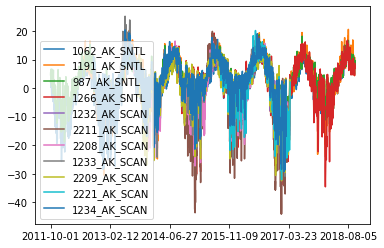

In [11]:
t.plot()

In [78]:
# # for CHUK domain - had to remove invalid data
# t['2213_AK_SCAN'].loc['2017-04-01':]=np.nan
# out = dataPath + 'SNOTEL_data_TOBScelsius'+st_dt+'_'+ed_dt+'.csv'
# t.to_csv(out)

In [12]:
######## PREC ########
# PATHS
dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'
p = pd.read_csv(dataPath+'Station_data_PRmeters_'+st_dt+'_'+ed_dt+'.csv',index_col=0)
p

,1062_AK_SNTL,1191_AK_SNTL,987_AK_SNTL,1266_AK_SNTL,1232_AK_SCAN,2211_AK_SCAN,2208_AK_SCAN,1233_AK_SCAN,2062_AK_SCAN,2209_AK_SCAN,2063_AK_SCAN,2221_AK_SCAN,1234_AK_SCAN
2011-10-01,0.01016,NaN,0.00762,NaN,NaN,NaN,NaN,NaN,0.004064,NaN,0.004826,NaN,NaN
2011-10-02,0.01778,NaN,0.00508,NaN,NaN,NaN,NaN,NaN,0.016256,NaN,0.014478,NaN,NaN
2011-10-03,0.00000,NaN,0.01778,NaN,NaN,NaN,NaN,NaN,0.000762,NaN,0.000508,NaN,NaN
2011-10-04,0.00000,NaN,0.00254,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN
2011-10-05,0.00254,NaN,0.03048,NaN,NaN,NaN,NaN,NaN,0.001778,NaN,0.002286,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,0.00508,0.00000,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-27,0.04318,0.04318,0.03048,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-28,0.00762,0.01016,0.00508,0.00762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-29,0.00254,0.00000,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


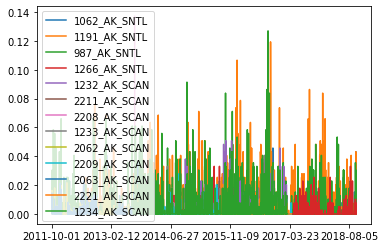

In [13]:
p.plot()

In [14]:
######## SWED ########
# PATHS
dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'
swe = pd.read_csv(dataPath+'Station_data_SWEDmeters_'+st_dt+'_'+ed_dt+'.csv',index_col=0)
swe

,1062_AK_SNTL,987_AK_SNTL,1266_AK_SNTL
2011-10-01,0.0,0.0,NaN
2011-10-02,0.0,0.0,NaN
2011-10-03,0.0,0.0,NaN
2011-10-04,0.0,0.0,NaN
2011-10-05,0.0,0.0,NaN
...,...,...,...
2018-09-26,0.0,0.0,0.0
2018-09-27,0.0,0.0,0.0
2018-09-28,0.0,0.0,0.0
2018-09-29,0.0,0.0,0.0


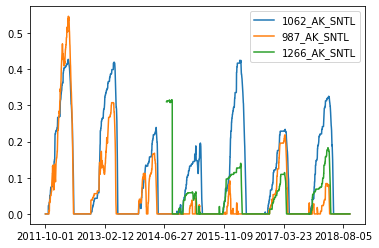

In [ ]:
swe.plot()

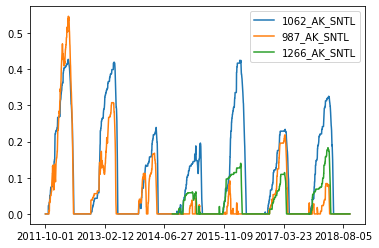

In [19]:
# remove questionable swe points at the start of 1266_AK_SNTL timeseries
swe['1266_AK_SNTL'] = swe['1266_AK_SNTL'].where(swe['1266_AK_SNTL']<.25,np.nan)
swe.plot()

In [20]:
# resave edited swe data
out = dataPath + 'Station_data_SWEDmeters_'+st_dt+'_'+ed_dt+'.csv'
swe.to_csv(out)

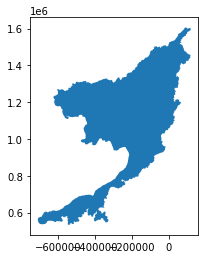

In [5]:
#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()
# huc2 vector file
shp = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/gis/'+domain+'/BRIS.json')
# projected coordinates
shpproj = shp.to_crs(domains[domain]['mod_proj'])
shpproj.plot()

/nfs/attic/dfh/2020_NPRB/data/snotel/BRIS/Station_sites_SWEDmeters_BRIS_2011-10-01_2018-09-30.geojson: No such file or directory
driver GeoJSON does not support creation option ENCODING


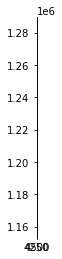

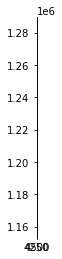

In [12]:
######## SWED ########
dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'
# gdf path
gdfpath = dataPath + 'Station_sites_SWEDmeters_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson'
# open gdf
Sgdf = gpd.read_file(gdfpath)
Sgdf.plot()
#stn data
sdatapath = dataPath + 'Station_data_SWEDmeters_'+st_dt+'_'+ed_dt+'.csv'
# open stn data
s = pd.read_csv(sdatapath,index_col=0)
# clip station in domain bouning box to yuko watershed
stn_clip = gpd.clip(Sgdf, shpproj).reset_index(drop=True)
stn_clip.plot()
# save updated gdf
stn_clip.to_file(gdfpath, driver='GeoJSON')
# select data from stations in domain 
s2 = s[s.columns.intersection(stn_clip.code)]
s2.to_csv(sdatapath)

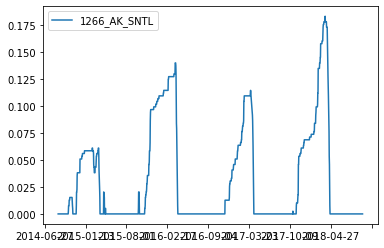

In [14]:
s2.plot()